## Plot for Frequency change overtime and their corresponding DEG counts In ARI 

In [1]:

# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(ggrepel)
options(warn = -1)


In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy 
             = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")

cluster_colors_ext <- colorRampPalette(cluster_colors)(75)
options(repr.plot.width = 20, repr.plot.height = 15)

In [4]:
#loading aim 3 deg results file
degs_a3=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/certpro_Zi_files/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3_mixed_models_time_result_750days.csv")
degs_a3%>%head(3)

,celltype,effect,group,term,estimate,std.error,statistic,df,p.value,gene,q_values,sig
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,Adaptive NK cell,fixed,NA,days_to_conversion,-4.601178e-04,0.0001726325,-2.6653027,43.00000,0.01079008,AAK1,0.3471929,ns
2,Adaptive NK cell,fixed,NA,days_to_conversion,2.698218e-04,0.0001816877,1.4850857,43.00000,0.14481591,AASDHPPT,0.5004335,ns
3,Adaptive NK cell,fixed,NA,days_to_conversion,-1.742457e-05,0.0001246150,-0.1398272,42.98683,0.88944965,AATF,0.7853112,ns


In [5]:
##adding the direction column

degs_a3=degs_a3%>%
    filter(!is.na(p.value) & !is.na(estimate)) %>% mutate(direction=if_else(estimate>0, 'positive', 'negative'))
degs_a3 %>% head(3)

,celltype,effect,group,term,estimate,std.error,statistic,df,p.value,gene,q_values,sig,direction
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,Adaptive NK cell,fixed,NA,days_to_conversion,-4.601178e-04,0.0001726325,-2.6653027,43.00000,0.01079008,AAK1,0.3471929,ns,negative
2,Adaptive NK cell,fixed,NA,days_to_conversion,2.698218e-04,0.0001816877,1.4850857,43.00000,0.14481591,AASDHPPT,0.5004335,ns,positive
3,Adaptive NK cell,fixed,NA,days_to_conversion,-1.742457e-05,0.0001246150,-0.1398272,42.98683,0.88944965,AATF,0.7853112,ns,negative


In [6]:
deg_counts <- degs_a3 %>%dplyr::filter(q_values<0.1) %>% 
  group_by(celltype, direction) %>%
  summarise(deg_counts = n())
deg_counts %>% head()


`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


celltype,direction,deg_counts
<chr>,<chr>,<int>
CD27+ effector B cell,negative,1
CD27+ effector B cell,positive,3
CM CD4 T cell,negative,1418
CM CD4 T cell,positive,1294
CM CD4 T cell_uk1_CD8,positive,1
CM CD8 T cell,negative,31


In [7]:
# getting the absolute count of DEGs 
total_degs<- deg_counts %>% 
    group_by(celltype) %>% 
    summarize(total_degs_counts = sum(abs(deg_counts))) %>%
    arrange(desc(total_degs_counts))
total_degs%>%dim
total_degs%>%head()

[1] 19  2

celltype,total_degs_counts
<chr>,<int>
CM CD4 T cell,2712
Core naive CD4 T cell,2651
Core naive CD8 T cell,305
KLRF1+ GZMB+ CD27- EM CD8 T cell,209
KLRF1- GZMB+ CD27- EM CD8 T cell,181
GZMK+ CD27+ EM CD8 T cell,59


In [8]:
# Loading the DA results
frequency_a3=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/certpro_Zi_files/DA_results/ALTRA_scRNA_AIFI_L3_deepclean_certpro_AIM3_DA_mixed_model_female_results.csv")
frequency_a3%>%head(3)
frequency_a3%>%dim

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688


[1] 80 11

In [9]:
merged_df <- left_join(frequency_a3, total_degs, by = "celltype")
merged_df%>%head(3)
merged_df%>%dim

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688,NA


[1] 80 12

In [10]:
#Creating a new column "Total_DEGs" and fill 0 for NA values in total_degs_counts
merged_df <- merged_df %>% mutate(Total_DEGs = ifelse(is.na(total_degs_counts), 0, total_degs_counts))
merged_df%>%head(2)
merged_df %>%filter(is.na(Total_DEGs))%>%dim

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts,Total_DEGs
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA,0
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA,0


[1]  0 13

In [11]:
# Reading the IH color file
IH_color_df=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/Color_Annotation_and_Order_FINAL 1.csv")
IH_color_df <- IH_color_df %>% rename(celltype = label)
IH_color_df%>%head(3)

,xpos,celltype,color
,<int>,<chr>,<chr>
1,1,SOX4+ naive CD4 T cell,#2B5777
2,2,Core naive CD4 T cell,#597FC6
3,3,ISG+ naive CD4 T cell,#072E77


In [12]:
# merging it with the merged df of DA and DEG results
merged_df<- left_join(merged_df, IH_color_df, by = "celltype")
merged_df%>%head(3)
merged_df%>%dim

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts,Total_DEGs,xpos,color
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA,0,NA,NA
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA,0,62,#8C6527
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688,NA,0,1,#2B5777


[1] 80 15

In [13]:
# Aggregate score for the size of the bubble 
merged_df <- merged_df %>%
  mutate(adjP_degs_combined_value = -log10(p.value.adj) * Total_DEGs)
merged_df%>%head(3)
merged_df%>%dim

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts,Total_DEGs,xpos,color,adjP_degs_combined_value
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<dbl>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA,0,NA,NA,0
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA,0,62,#8C6527,0
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688,NA,0,1,#2B5777,0


[1] 80 16

In [14]:
# to display the name of only signifcant celltype names in the plot 
merged_df <- merged_df %>%
  mutate(sig_L3 = if_else(adjP_degs_combined_value > 1, celltype, NA_character_))
merged_df%>%head(3)

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts,Total_DEGs,xpos,color,adjP_degs_combined_value,sig_L3
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<dbl>,<chr>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA,0,NA,NA,0,NA
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA,0,62,#8C6527,0,NA
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688,NA,0,1,#2B5777,0,NA


In [15]:
#scaling the estimate by year 
merged_df <- merged_df %>% mutate(estimate_by_year = estimate*365)
merged_df%>%head()

,AIFI_L3_new,effect,group,term,estimate,std.error,statistic,df,p.value,celltype,p.value.adj,total_degs_counts,Total_DEGs,xpos,color,adjP_degs_combined_value,sig_L3,estimate_by_year
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<dbl>,<chr>,<dbl>
1,ASDC_uk1_B,fixed,NA,days_to_conversion,-0.0009195660,0.0003201099,-2.872657,46.00000,0.006138637,ASDC_uk1_B,0.3157688,NA,0,NA,NA,0,NA,-0.3356416
2,ISG+ cDC2,fixed,NA,days_to_conversion,-0.0008794109,0.0003189739,-2.757000,42.68049,0.008548418,ISG+ cDC2,0.3157688,NA,0,62,#8C6527,0,NA,-0.3209850
3,SOX4+ naive CD4 T cell,fixed,NA,days_to_conversion,-0.0006232588,0.0002460128,-2.533440,37.18069,0.015640822,SOX4+ naive CD4 T cell,0.3157688,NA,0,1,#2B5777,0,NA,-0.2274894
4,DN T cell,fixed,NA,days_to_conversion,0.0004714277,0.0001865621,2.526921,38.01167,0.015788439,DN T cell,0.3157688,NA,0,15,#656E68,0,NA,0.1720711
5,Intermediate monocyte,fixed,NA,days_to_conversion,-0.0010331483,0.0004630083,-2.231382,46.00000,0.030570438,Intermediate monocyte,0.3587922,NA,0,56,#B75228,0,NA,-0.3770991
6,Plasma cell,fixed,NA,days_to_conversion,0.0007494933,0.0003448256,2.173543,44.75029,0.035071132,Plasma cell,0.3587922,NA,0,46,#784D47,0,NA,0.2735650


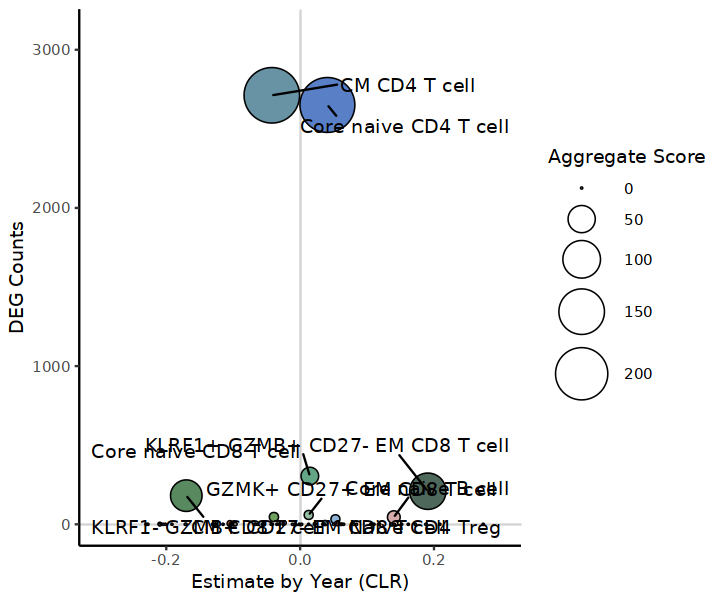

In [17]:
options(repr.plot.width = 6, repr.plot.height = 5)
cell_type_colors <- setNames(merged_df$color, merged_df$celltype)
p <- ggplot(merged_df, aes(x =estimate_by_year, y = Total_DEGs, size = adjP_degs_combined_value, fill = celltype)) +
  geom_hline(yintercept = 0, color = "lightgray", size = 0.5) + 
  geom_vline(xintercept = 0, color = "lightgray", size = 0.5) + 
  geom_point(shape = 21, colour = "black") +
  theme_classic() +
  scale_size_continuous(range = c(0.02, 15), limits = c(0, max(merged_df$adjP_degs_combined_value))) +
 
  xlab("Estimate by Year (CLR)") +
  ylab("DEG Counts") +
  theme(legend.position = "right") +
  scale_fill_manual(values = cell_type_colors) +
  scale_x_continuous(limits = c(-0.3, 0.3)) +
  guides(fill = "none", size = guide_legend("Aggregate Score")) + 
  geom_text_repel(
    data = merged_df %>% filter(celltype %in% sig_L3),
    box.padding = 0.5,
    force = 0.5,
    max.overlaps = 50,
    nudge_x = 0.1,
    nudge_y=2,
    hjust = 0.1,
    segment.size = 0.5,
    mapping = aes(label = celltype),
    size = 4
  ) +
  theme(
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank()   # Remove minor grid lines
  )+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.2)))
p

In [18]:
ggsave("/home/jupyter//ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_2C.pdf", plot = p, width = 6, height = 5)


In [19]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.5               plotly_4.10.4              
 [3] knitr_1.47                  ggpubr_0.6.0               
 [5] SeuratDisk_0.0.0.9021       SingleCellExperiment_1.22.0
 [7] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [9] GenomicRanges_1.52.1        Genome